### **FinBERT + 강화학습을 활용한 [모멘텀+뉴스] 최적 멀티팩터 포트폴리오 찾기** <br>

"뉴스 기사가 금융 팩터 역할을 할 수 있을까?"   

**[FinBERT를 활용한 뉴스 팩터화]**
1. pre-trained FinBERT를 통해 뉴스 제목으로부터 negative 점수 추출
2. 뉴스 발생 이후 negative 유효 기간은 5일로 설정

**[모멘텀 팩터와 뉴스 팩터 결합]** 
1. 3일 모멘텀 (D3), 7일 모멘텀 (D7), 14일 모멘텀 (D14) 팩터를 뉴스 팩터 (NEWS)와 결합
2. 최종적으로 **모멘텀+뉴스** 멀티팩터 포트폴리오 구성

**[유니버스 및 포트폴리오 구성]**
1. 뉴스 발생 비중 30퍼센트 이상인 종목 300개를 투자 유니버스로 설정
2. 각 팩터 점수 총합 상위 30개를 포트폴리오에 편입
3. 각 종목 보유 비중은 동일 가중으로 설정하고 3일마다 리밸런싱

**[강화학습을 활용한 팩터 가중치 최적화]**
1. 각 팩터 점수에 줄 수 있는 가중치를 강화학습 (DDPG)으로 최적화
2. 샤프지수를 최대화하는 방향으로 학습
3. 최종적인 최적 팩터 가중치는 ***D3: 58%, D7:7%, D14:11%, NEWS:22%***

In [ ]:
cd ..

In [24]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

from typing import List
from typing import Tuple
from typing import Iterable
from numpy.random import random
from datetime import datetime
from collections import deque

np.set_printoptions(suppress=True)
st = datetime.strptime

#### 뉴스 팩터 역할에 대한 대조 실험
뉴스 팩터 포함 여부에 따라 포트폴리오의 성과 차이가 나는지 <br>
아래의 두 포트폴리오를 비교하는 대조 실험을 진행한다. 

1. 모멘텀 팩터 포트폴리오
2. 모멘텀 팩터 + **뉴스** 팩터 포트폴리오

In [45]:
class Metrics:
    """
    평가 지표 계산 메서드 모음
    """
    
    def get_mdd(self, pvs:list):
        df = pd.DataFrame(pvs)
        premaxs = df.cummax()
        drawdowns = (1-df / premaxs) * 100
        mdd = drawdowns.max().iloc[0]
        return mdd

    def get_sr(self, pvs:list):
        free = ((0.04) / 250) * 3
        pvs = np.array(pvs)
        pct = (pvs[1:] - pvs[:-1]) / pvs[:-1]
        ratio = np.mean(pct - free) / np.std(pct)
        return ratio

class Portfolio:
    """
    포트폴리오 객체
    """
    def __init__(self, ticker:Iterable[str], weight:Iterable[float]):
        self.ticker = np.array(ticker)
        self.weight = np.array(weight)
        self.dict = self.__get_dict()
    
    def update_weight(self, weight:Iterable[float]):
        self.weight = np.array(weight)
        self.dict = self.__get_dict()

    def update_ticker(self, ticker:Iterable[str]):
        self.ticker = np.array(ticker)
        self.dict = self.__get_dict()

    def __repr__(self) -> str:
        return f"{self.dict}"

    def __len__(self) -> int:
        return len(self.dict)

    def __get_dict(self) -> dict:
        return dict(zip(self.ticker, self.weight))
    
class Order: 
    """
    오더 객체
    """
    def __init__(self):
        self.ticker = np.array([])
        self.size = np.array([]) 
        self.dict = self.__get_dict()

    def append(self, ticker:Iterable[str], size:Iterable[float]):
        self.ticker = np.append(self.ticker, ticker)
        self.size = np.append(self.size, size)
        self.dict = self.__get_dict()

    def __repr__(self) -> str:
        return f"{self.dict}"
    
    def __get_dict(self) -> dict:
        return dict(zip(self.ticker, self.size))

In [46]:
class FactorManager:

    """
    투자 유니버스가 되는 종목들의 데이터를 관리한다.

    [Factors]
    'D3', 'D7', 'D14', 'NEWS'
    """

    path1 = 'data/factors.csv'
    path2 = 'data/price.csv'

    def __init__(self, config):    
        """
        all: 전 종목의 모든 팩터의 값을 담고 있는 데이터프레임
        price: 전 종목의 종가 값을 담고 있는 데이터프레임
        
        [Ex: all]
        종목코드  기준일       팩터     값
        AAPL  2023-01-03    D3      0.04707
        AAPL  2023-01-04    D7      0.0786
        ...     ...         ...     ...
        NVDA  2023-08-30    NEWS    0.008364
        """    
        self.all = pd.read_csv(self.path1, index_col=0, dtype={'종목코드':str})
        self.price = pd.read_csv(self.path2, index_col=0)
        self.factors = config['Factors']
        self.scores_by_date = []
    
    def get_FactorData(self, name:str) -> pd.DataFrame:
        """
        하나의 팩터 이름을 받아, 
        해당 팩터의 전 종목에 대한 값 데이터를 리턴

        
        [Ex: self.get_FactorData('D7')]
        종목코드      AAPL     NVDA     ACHC     ADTN  ... 
        기준일
        
        2023-01-03  0.03984 0.06998  0.03678  0.03482 ...   
        2023-01-04  0.03820 0.09536  0.09001  0.09153 ...
        ...
        2023-08-30
        """

        factor_data = self.all[self.all['팩터'] == name][['종목코드', '날짜', '값']]
        factor_data = factor_data.pivot(index='날짜', columns='종목코드', values='값')
        return factor_data
    
    def get_ScoreEACH(self, date:str) -> pd.DataFrame:
        """
        특정 Date에서 각 종목들의 팩터별 스코어 데이터 리턴

        
        [Ex: self.get_ScoreEACH('2023-01-31')]
        팩터       D3      D7   ...          NEWS
        종목코드
        AAPL      1.0     9.0   41.0   ...   45.0
        NVDA      13.0    5.0   13.0   ...   1.0 
        ...
        ACHC      8.0     16.0  20.0   ...   13.0
        """
        values = self.all[self.all['날짜'] == date][['종목코드', '팩터', '값']]
        values = values.pivot(index='종목코드', columns='팩터', values='값')

        factor_score = values[self.factors]
        factor_score = factor_score.apply(self.rankin_func)
        factor_score = factor_score.apply(self.minmax_func)
        factor_score = factor_score.apply(self.weight_func)
        return factor_score
    
    def get_RankALL(self):
        """
        팩터 점수를 합하여 토탈 랭킹 데이터 리턴

        
        [Ex: self.get_RankALL()]
        종목코드        AAPL  NVDA  ACHC   ADTN  ... 
        기준일
        
        2023-01-03    9.0     7.0     17.0    2.0 ...   
        2023-01-04    9.0     6.0     1.0     51.0 ...
        ...
        2023-08-30 
        """
        dates = self.price.index

        self.scores_by_date = [self.get_ScoreEACH(date)[self.factors] for date in dates] \
            if not self.scores_by_date else self.scores_by_date
        
        func1 = lambda df:df.apply(self.weight_func)
        func2 = lambda df:df.sum(axis=1).rank(method='first', ascending=False)

        rank_all = map(func1, self.scores_by_date)
        rank_all = map(func2, rank_all)
        rank_all = pd.concat(rank_all, axis=1).transpose()
        rank_all.index = dates
        return rank_all
    
    def set_w(self, value=None):
        """
        각 팩터의 가중치를 결정하는 함수
        """
        self.weight_dict = \
            dict(zip(self.factors, np.ones(len(self.factors)))) if value is None else \
            dict(zip(self.factors, value))
        

    def rankin_func(self, series):
        return series.rank(method='first')
    
    def weight_func(self, series):
        return series*self.weight_dict[series.name]
    
    def minmax_func(self, series):
        return (series-min(series)) / (max(series)-min(series)) + 1

In [47]:
class BackTester(Metrics, FactorManager):
    """
    백테스팅을 위한 시뮬레이터
    """
    def __init__(self, config):
        FactorManager.__init__(self, config)
        
        self.config = config
        self.set_w()

    def init(self, w:np.array=None):
        """
        백테스트에 필요한 랭킹 테이블 로드
        FactorWeight: 각 팩터 스코어의 가중치

        [Ex: FactorWeight]
        FactorWeight = [0.12, 0.23, ..., 0.05]
        """
        self.set_w(w)
        self.rank_all = self.get_RankALL()
        self.universe = self.price
        
    def act(self, index:int, n:int, q:int=1) -> np.array:
        """
        특정 타임스텝에서 팩터 랭킹에 따른, 티커 리스트와 가중 벡터 리턴

        index: 데이터 타임스텝
        n: 포트폴리오 종목수
        q: 포트폴리오 분위 (top, btm)
        w: 포트폴리오 가중방식
        """

        tickers_all = self.universe.columns.to_numpy()        
        ticker = tickers_all[(self.rank_all.iloc[index].to_numpy() <= n * q) &
                             (self.rank_all.iloc[index].to_numpy() > n * (q-1))]

        # equal weighted 
        weight = np.ones(n) / n 
        return ticker, weight 


    def test(self):
        """ 
        [Return list]
        1. PVs: 타임스텝별 포트폴리오 벨류
        2. PFs: 타임스텝별 포트폴리오 수익률
        3. TIs: 타임스텝별 포트폴리오 티커
        4. POs: 타임스텝별 포트폴리오 비중
        5. result: 메트릭 값 포함 딕셔너리
        """
        PVs = []
        PFs = []
        POs = []
        TIs = []

        self.universe = self.universe
        self.rank_all = self.rank_all

        universe = self.universe
        rank_all = self.rank_all
        act = self.act

        cum_profit = 0
        balance = 0

        # 초기 평가 금액
        portfolio_value = \
            self.config['Balance']
        # 초기 투자 금액 
        init_balance = \
            self.config['Balance']
        # 포트폴리오 투자 자산수
        n = self.config['Number'] 

        for i in range(0, len(universe)):

            ticker_old, weight_old = act(i, n)
            p_old = Portfolio(ticker_old, weight_old) if i == 0 else p_old
            price_old = universe.iloc[i][p_old.ticker].values if i == 0 else price_old

            POs.append(p_old.weight)
            TIs.append(p_old.ticker)
            PVs.append(portfolio_value)
            PFs.append(cum_profit)
            
            # 여기는 get_price 함수로 (인자는 ticker 받도록)
            price_old = universe.iloc[i-1][p_old.ticker].values
            price_now = universe.iloc[i][p_old.ticker].values

            # 다음 타임 스텝에서 가격 변동으로 인한 포트폴리오 변화
            ratio = (price_now - price_old) / price_old
            ratio = np.where(np.isnan(ratio), np.float64(-0.99), ratio)

            profitloss = np.dot(ratio, p_old.weight)
            portfolio_value *= (1 + profitloss)
            cum_profit = ((portfolio_value / init_balance -1) * 100)

            weight_now = p_old.weight * (1+ratio) 
            weight_now = weight_now / np.sum(weight_now)

            p_old.update_weight(weight_now)
            
            # Desired Portfolio
            check = st(rank_all.index[i], '%Y-%m-%d').day & 3 == 0
            ticker, weight = act(i, n) if check else (p_old.ticker, p_old.weight)
            p_new = Portfolio(ticker, weight)

            """
            Order 계산
            """
            # Gap 계산 대상
            gap_ticker = p_old.ticker[np.isin(p_old.ticker, p_new.ticker)] 

            # Gap 사이즈
            gap_size = p_new.weight[np.isin(p_old.ticker, p_new.ticker)] - \
                p_old.weight[np.isin(p_old.ticker, p_new.ticker)]
            
            # 매도 대상
            sell_ticker = p_old.ticker[~ np.isin(p_old.ticker, p_new.ticker)]

            # 매도 대상 사이즈
            sell_size = -p_old.weight[~ np.isin(p_old.ticker, p_new.ticker)]

            # 매수 대상
            buy_ticker = p_new.ticker[~ np.isin(p_new.ticker, p_old.ticker)]

            # 매수 대상 사이즈
            buy_size = p_new.weight[~ np.isin(p_new.ticker, p_old.ticker)]

            # 오더
            order = Order()

            gap_order = (gap_ticker, gap_size)
            sell_order = (sell_ticker, sell_size)
            buy_order = (buy_ticker, buy_size)

            order.append(*gap_order)
            order.append(*sell_order)
            order.append(*buy_order)
                
            # 보유하고 있는 종목과 보유할 종목을 combine 해놓기
            combine = {}.fromkeys(order.ticker, 0.0)
            combine.update(p_old.dict)
            weight = np.fromiter(combine.values(), dtype=np.float64)
            
            """
            거래 
            """
            CHARGE = 0.000 #0.001
            TEX = 0.0000 #0.0025
            FEE = 0.0

            sell_cost = CHARGE + TEX
            buy_cost = CHARGE

            action = order.size

            # 매도 주문부터
            sell_ind = np.where( (action < 0) )[0]
            weight[sell_ind] += action[sell_ind]
            sell_moneys = portfolio_value * abs(action[sell_ind]) * (1.0-sell_cost)
            sell_amount = np.sum(sell_moneys) 
            balance += sell_amount
            FEE += sell_amount * sell_cost

            # 매수 주문 처리
            buy_ind = np.where( (action > 0) )[0]
            buy_moneys = portfolio_value * action[buy_ind] * (1.0+buy_cost)
            buy_amount = np.sum(buy_moneys) 

            allocation = buy_moneys / buy_amount

            buy_fee = balance * (buy_cost/(1+buy_cost)) 
            feasible_buy_moneys = (balance - buy_fee) * allocation 
            feasible_buy_amount = np.sum(feasible_buy_moneys)
            feasible_buy_action = feasible_buy_moneys / portfolio_value
            FEE += feasible_buy_amount * buy_cost # (= buy_fee)

            weight[buy_ind] += feasible_buy_action
            weight = weight / np.sum(weight)

            portfolio_value -= FEE
            balance -= feasible_buy_amount 

            p_old = Portfolio(order.ticker[weight>0], weight[weight>0])
        
        SR = round(self.get_sr(PVs), 4)
        MDD = round(self.get_mdd(PVs), 4)

        Result = {'sharpe': SR, 'mdd': MDD}
        
        return PVs, PFs, TIs, POs, Result

In [48]:
# 다음의 조합들을 벡테스팅한다.

test_comb = {1: ['D3', 'D7', 'D14', 'NEWS'],
             2: ['D3', 'D7', 'NEWS'],
             3: ['D3', 'D14', 'NEWS'],
             4: ['D7', 'D14', 'NEWS'],
             5: ['D3', 'NEWS'],
             6: ['D7', 'NEWS'],
             7: ['D14', 'NEWS'],
             8: ['D3', 'D7', 'D14'], 
             9: ['D3', 'D7'],
             10: ['D3', 'D14'],
             11: ['D7', 'D14'],
             12: ['D3'],
             13: ['D7'],
             14: ['D14']}

In [58]:
values = []

for i in range(1, 15):

    config = {'Number':30, 'Balance':1000, 
              'Factors':test_comb[i]}
    
    # obj
    bt = BackTester(config)

    # weight init
    bt.init()

    # PV, PF, TI, PO, {sharpe: , mdd: }
    result = bt.test()

    # pv list 
    values.append(result[0])

[비교 실험 1] <br>
조합1: 3일 모멘텀 (D3) + 7일 모멘텀 (D7) + 14일 모멘텀 (D14) + **뉴스 팩터** <br>
조힙2: 3일 모멘텀 (D3) + 7일 모멘텀 (D7) + 14일 모멘텀 (D14)

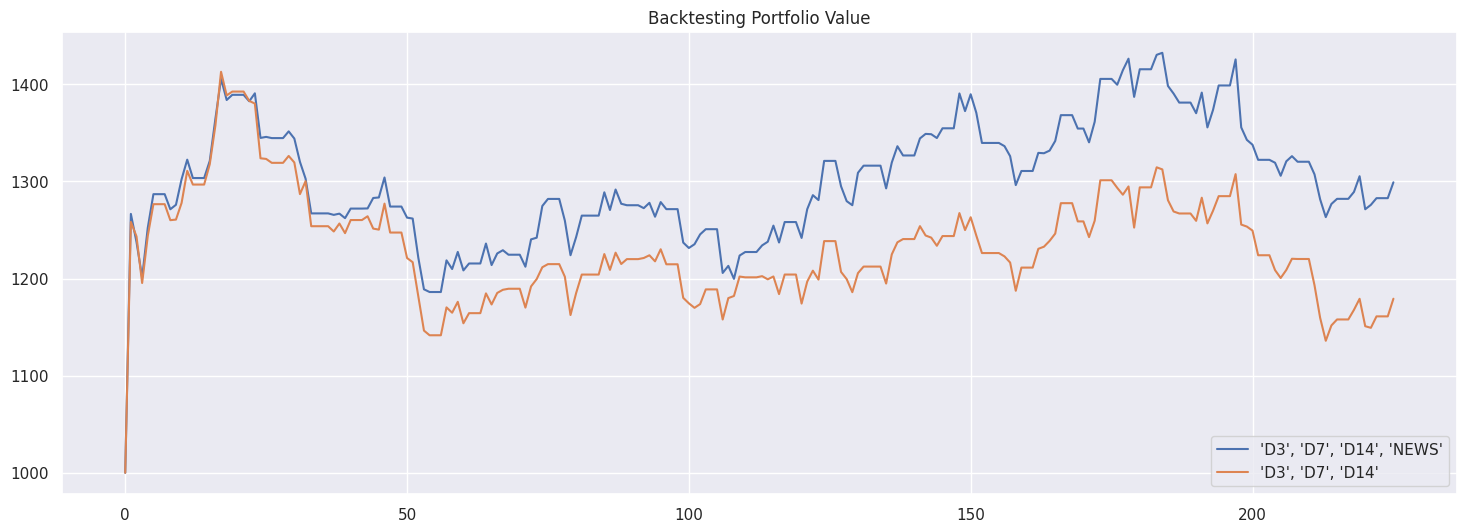

In [107]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[0], label="'D3', 'D7', 'D14', 'NEWS'")
plt.plot(values[7], label="'D3', 'D7', 'D14'")
plt.title('Backtesting Portfolio Value')
plt.legend()

[비교 실험 2] <br>
조합1: 3일 모멘텀 (D3) + 7일 모멘텀 (D7) + **뉴스 팩터** <br>
조힙2: 3일 모멘텀 (D3) + 7일 모멘텀 (D7) + 

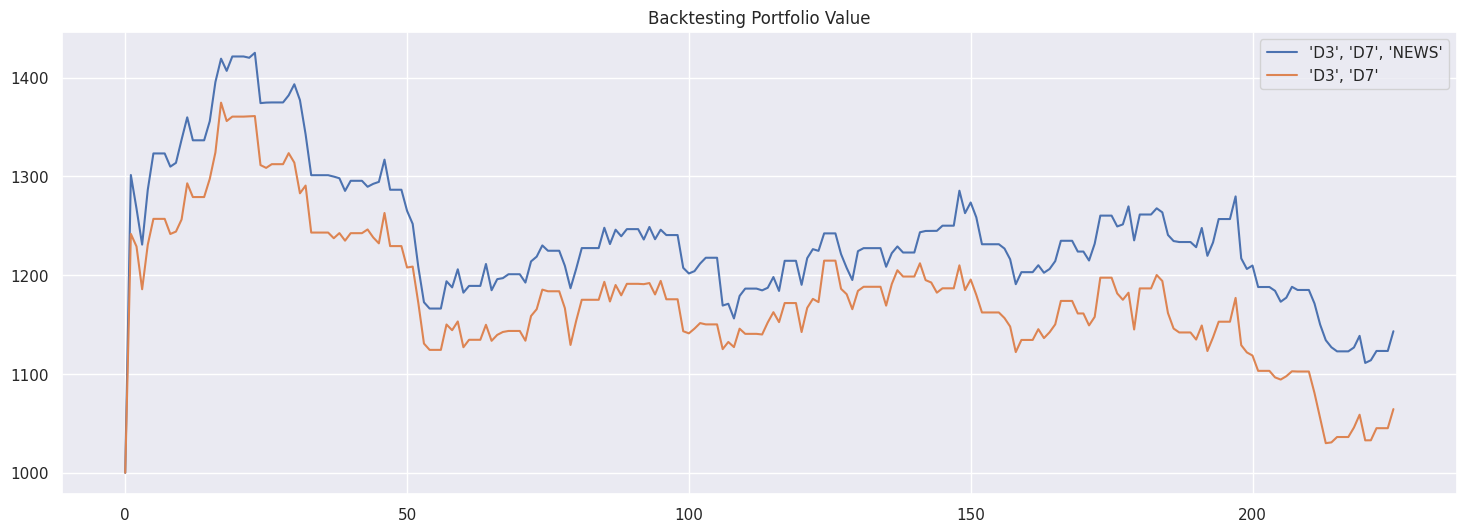

In [108]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[1], label="'D3', 'D7', 'NEWS'")
plt.plot(values[8], label="'D3', 'D7'")
plt.title('Backtesting Portfolio Value')
plt.legend()

[비교 실험 3] <br>
조합1: 3일 모멘텀 (D3) + 14일 모멘텀 (D14) + **뉴스 팩터** <br>
조힙2: 3일 모멘텀 (D3) + 14일 모멘텀 (D14) +

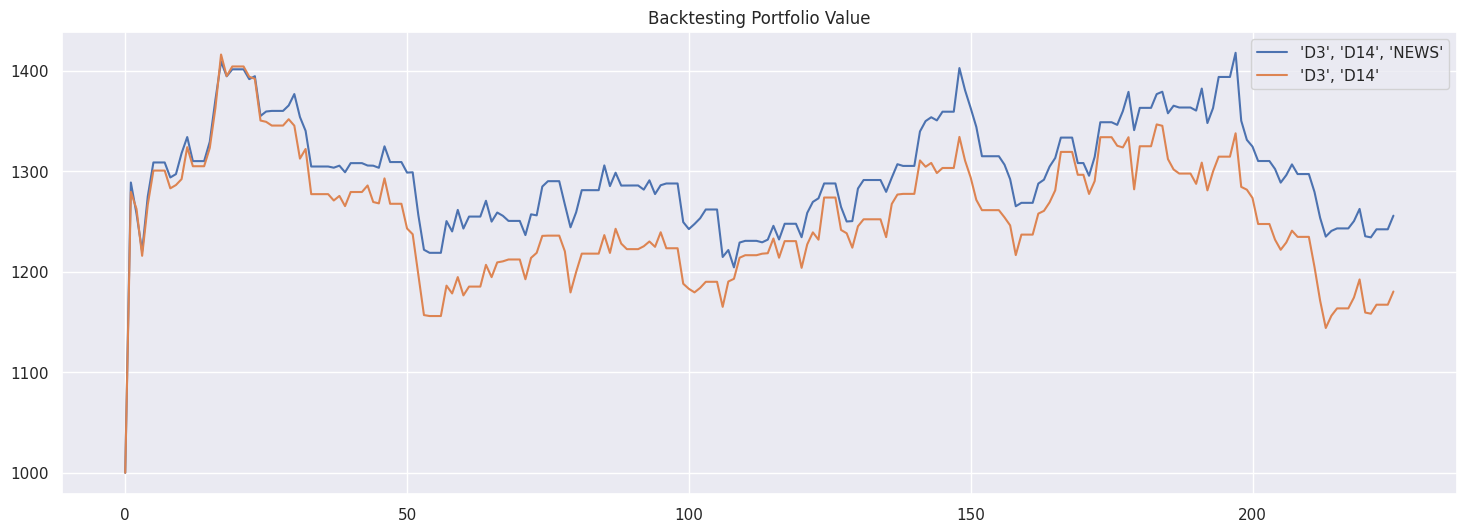

In [109]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[2], label="'D3', 'D14', 'NEWS'")
plt.plot(values[9], label="'D3', 'D14'")
plt.title('Backtesting Portfolio Value')
plt.legend()

[비교 실험 4] <br>
조합1: 7일 모멘텀 (D7) + 14일 모멘텀 (D14) + **뉴스 팩터** <br>
조힙2: 7일 모멘텀 (D7) + 14일 모멘텀 (D14) +

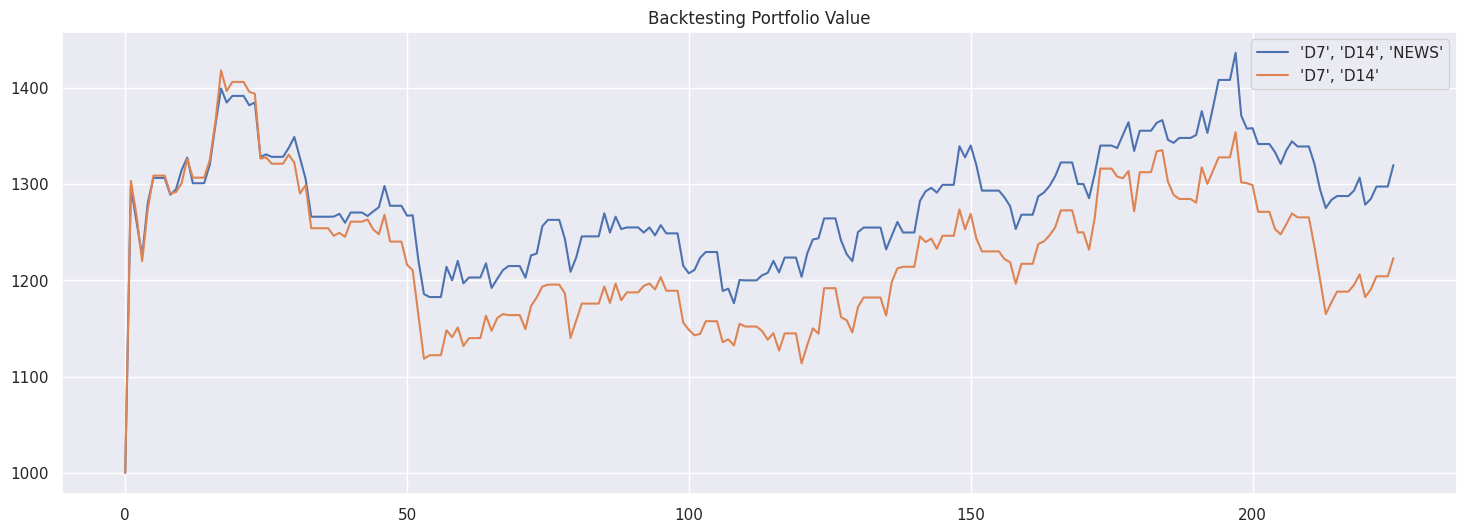

In [110]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[3], label="'D7', 'D14', 'NEWS'")
plt.plot(values[10], label="'D7', 'D14'")
plt.title('Backtesting Portfolio Value')
plt.legend()

[비교 실험 4] <br>
조합1: 3일 모멘텀 (D3) + **뉴스 팩터** <br>
조힙2: 3일 모멘텀 (D3)

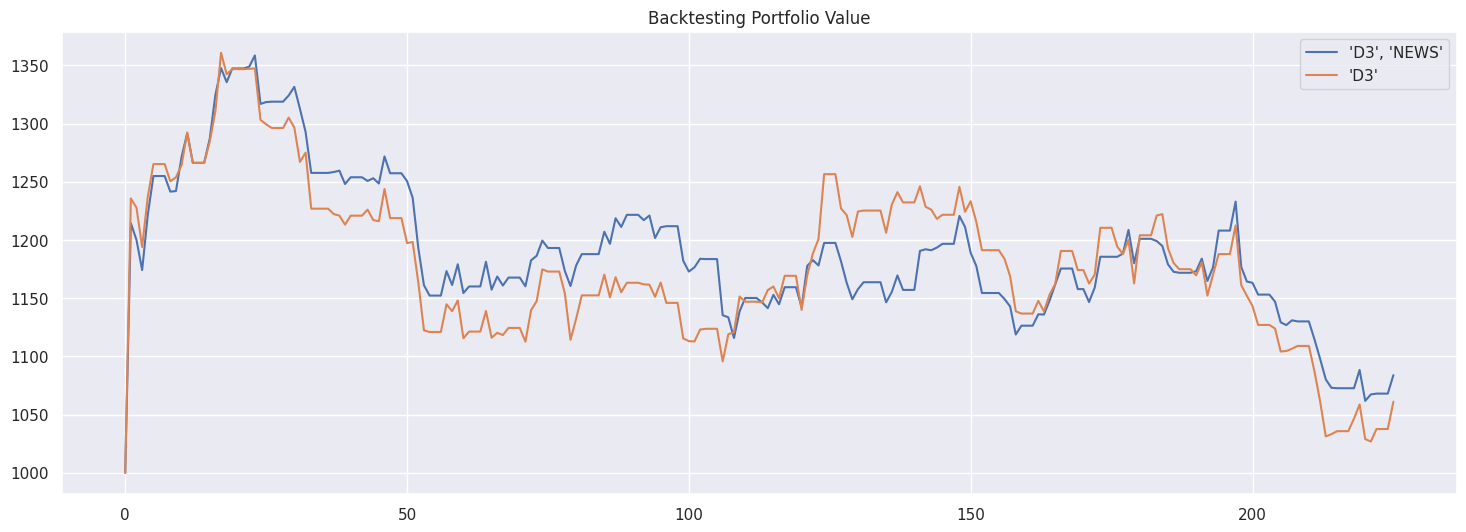

In [111]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[4], label="'D3', 'NEWS'")
plt.plot(values[11], label="'D3'")
plt.title('Backtesting Portfolio Value')
plt.legend()

[비교 실험 5] <br>
조합1: 7일 모멘텀 (D7) + **뉴스 팩터** <br>
조힙2: 7일 모멘텀 (D7)

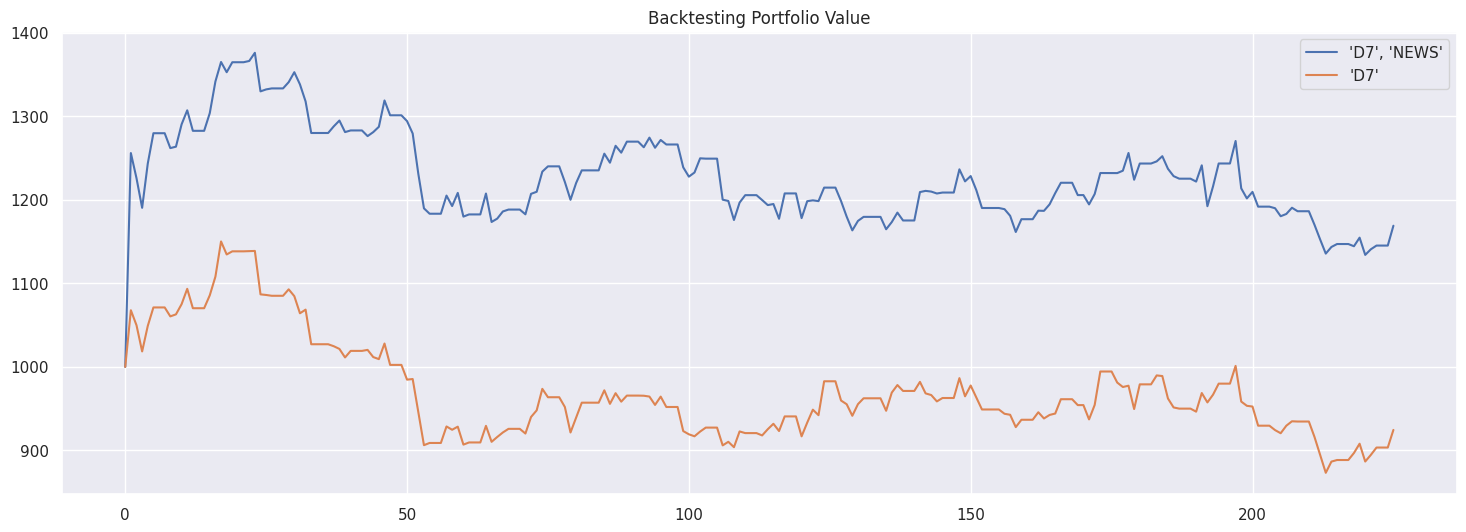

In [112]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[5], label="'D7', 'NEWS'")
plt.plot(values[12], label="'D7'")
plt.title('Backtesting Portfolio Value')
plt.legend()

[비교 실험 6] <br>
조합1: 14일 모멘텀 (D14) + **뉴스 팩터** <br>
조힙2: 14일 모멘텀 (D14)

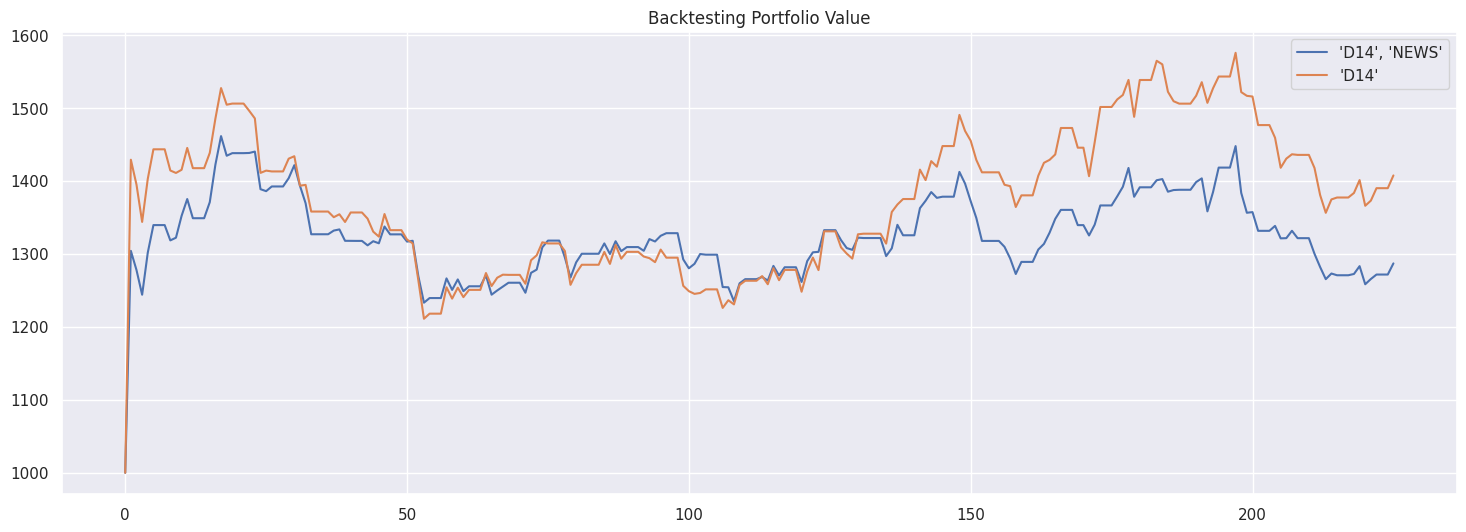

In [113]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[6], label="'D14', 'NEWS'")
plt.plot(values[13], label="'D14'")
plt.title('Backtesting Portfolio Value')
plt.legend()

#### 강화학습을 활용한 팩터 가중치 최적화
위의 실험 결과는 각 팩터 점수를 동일 가중으로 합하여 최종 스코어를 계산한다. <br>
하지만 팩터 별 가중치에 따라 포트폴리오 성과가 달라지므로 가중치를 <br>
다음의 강화학습 알고리즘으로 최적화 한다.

1. action = factor weight vector
2. reward = sharpe ratio
3. algorithm = DDPG (deep deterministic policy gradient)

In [49]:
class Mask(nn.Module):
    """
    팩터 가중치를 주는 Mask 네트워크
    """
    def __init__(self, dim):
        super().__init__()
        
        self.sigma = 1.0
        self.noise = torch.randn(dim)
        self.mu = torch.tensor([3.0] * dim)
        self.mu = nn.Parameter(self.mu)

    def sample(self, noisy=True):
        noise = self.sigma * self.noise.normal_()
        mask = self.mu + noise*noisy
        mask = torch.softmax(mask, dim=0) 
        mask = torch.clamp(mask, 0.0, 1.0)
        return mask


class Rnet(nn.Module):
    """
    Q network
    """
    def __init__(self, dim):
        super().__init__()
        self.layer1 = nn.Linear(dim, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 1)

        self.BN1 = nn.BatchNorm1d(256)
        self.BN2 = nn.BatchNorm1d(128)
        self.act = nn.ReLU()

    def forward(self, w):
        x = self.layer1(w)
        x = self.BN1(x)
        x = self.act(x)
        x = self.layer2(x)
        x = self.BN2(x)
        x = self.act(x)
        x = self.layer3(x)
        return x

In [50]:
import random


class RLSEARCH(BackTester):
    """ 
    강화학습을 위한 에이전트 클래스
    """
    def __init__(self, config):
        BackTester.__init__(self, config)

        dim = config['Dim']
        self.mnet = Mask(dim)
        self.rnet = Rnet(dim)
        self.mse = torch.nn.MSELoss()

        self.opt_r = torch.optim.Adam(self.rnet.parameters(), lr=1e-4)
        self.opt_a = torch.optim.Adam(self.mnet.parameters(), lr=2e-3)
    
    def save(self, path):
        torch.save(self.mnet.state_dict(), path)
        torch.save(self.rnet.state_dict(), path)

    def get_w(self, noise=True):
        """
        Policy로부터 팩터 가중치 샘플링
        """
        return self.mnet.sample(noise).cpu()

    def get_r(self, result:dict):
        """
        결과 메트릭으로부터 reward 계산
        """
        reward = result['sharpe']
        reward = torch.tensor([reward])
        return reward
        
    def update(self, w, r):
        """
        DDPG 스타일 업데이트
        """
        # R network update
        r_hat = self.rnet(w.detach())
        r_loss = self.mse(r_hat, r)
        
        self.opt_r.zero_grad()
        r_loss.backward()
        self.opt_r.step()

        # Policy update
        w_loss = -self.rnet(w).mean()

        self.opt_a.zero_grad()
        w_loss.backward(retain_graph=True)
        self.opt_a.step()
        return r_loss.item(), w_loss.item()
        
    def search(self, iter):
        """
        RL 에이전트 학습 Loop
        """
        
        w_tensor = deque(maxlen=100)
        r_tensor = deque(maxlen=100)
        score = 0
        batch_size = 32

        for i in range(iter):
            weight = self.get_w()
            self.init(weight.detach().numpy())
            result = self.test()[-1]
            reward = self.get_r(result)

            score += 0.01 * (reward.item() - score)
            w_tensor.append(weight)
            r_tensor.append(reward)

            if len(w_tensor) >= batch_size:
                w_batch = random.sample(w_tensor, batch_size)
                r_batch = random.sample(r_tensor, batch_size)

                w_batch = torch.stack(w_batch).float()
                r_batch = torch.stack(r_batch).float()
                
                r_loss, w_loss = self.update(w_batch, r_batch)

                print(f'iter:{i}')
                print(f'score:{score}')
                print(f'r loss:{r_loss}')
                print(f'w loss:{w_loss}')
                print(f'{self.get_w(False).detach()}\n')

In [51]:
config_ = {'Number':30, 'Balance':1000, 'Dim':len(test_comb[1]),
           'Factors':test_comb[1]}

agent = RLSEARCH(config_)

In [52]:
# 10000 step 학습

agent.search(10000)

iter:31
score:0.009343308831090028
r loss:0.09376368671655655
w loss:0.04911155253648758
tensor([0.2493, 0.2502, 0.2502, 0.2502])

iter:32
score:0.009515875742779128
r loss:0.05976903811097145
w loss:0.046703826636075974
tensor([0.2488, 0.2506, 0.2507, 0.2499])

iter:33
score:0.009804716985351337
r loss:0.039190586656332016
w loss:0.039819978177547455
tensor([0.2485, 0.2510, 0.2511, 0.2494])

iter:34
score:0.010140669815497824
r loss:0.028669655323028564
w loss:0.034002408385276794
tensor([0.2482, 0.2513, 0.2513, 0.2492])

iter:35
score:0.010450263117342845
r loss:0.021083131432533264
w loss:0.02329571545124054
tensor([0.2479, 0.2517, 0.2513, 0.2491])

iter:36
score:0.010490760486169417
r loss:0.017195122316479683
w loss:0.015238432213664055
tensor([0.2477, 0.2522, 0.2510, 0.2491])

iter:37
score:0.010832852881307723
r loss:0.022146407514810562
w loss:0.011067038401961327
tensor([0.2477, 0.2526, 0.2507, 0.2489])

iter:38
score:0.010815524352494646
r loss:0.015986433252692223
w loss:0.0

In [53]:
config = {'Number':30, 'Balance':1000, 
          'Factors':['D3', 'D7', 'D14', 'NEWS']}

bt = BackTester(config)
bt.init([0.5840, 0.0719, 0.1168, 0.2273])
result = bt.test()

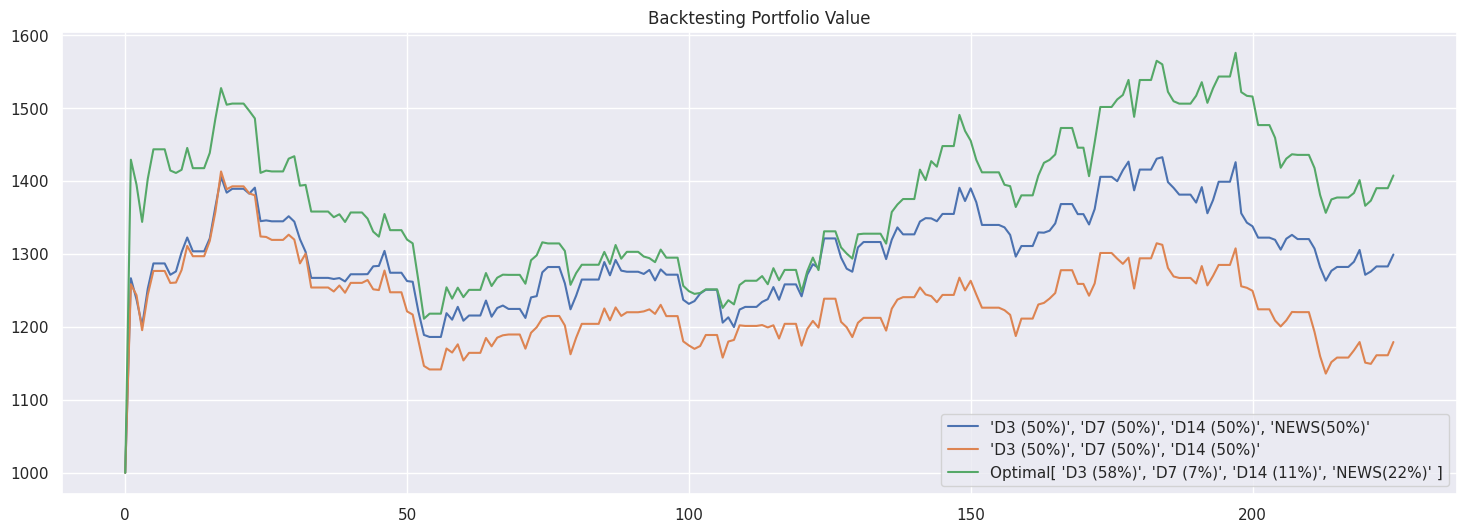

In [64]:
sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.plot(values[0], label="'D3 (50%)', 'D7 (50%)', 'D14 (50%)', 'NEWS(50%)'")
plt.plot(values[7], label="'D3 (50%)', 'D7 (50%)', 'D14 (50%)'")
plt.plot(result[0], label="Optimal[ 'D3 (58%)', 'D7 (7%)', 'D14 (11%)', 'NEWS(22%)' ]")
plt.title('Backtesting Portfolio Value')
plt.legend()